## Imports & Setup

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
print(f"Using device: {device}")

Using device: cuda


In [3]:
LEARNING_RATE = 0.0005
BATCH_SIXE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURE_CRITIC = 64
FEATURE_GEN = 64
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01


## The Critic

In [4]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            # CHANGE: BatchNorm2d -> InstanceNorm2d
            nn.InstanceNorm2d(out_channels, affine=True), 
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.critic(x)

## The Generator

In [5]:
class Generator(nn.Module):
    def __init__(self,z_dim,channels_img , features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim , features_g * 16 , 4,1,0),
            self._block(features_g * 16 , features_g * 8,4,2,1),
            self._block(features_g * 8 , features_g * 4,4,2,1),
            self._block(features_g * 4 , features_g * 2,4,2,1),

            nn.ConvTranspose2d(features_g *2 , channels_img , kernel_size =4 , 
            stride = 2 , padding = 1),
            nn.Tanh()
        )

    def _block(self,in_channels, out_channels , kernel_size =4 , stride =2, padding = 0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels , out_channels , 
            kernel_size , stride , padding , bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),

        )

    def forward(self,x):
        return self.gen(x)


## Gradient Penalty

In [6]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    
    # 1. Create interpolated images (epsilon)
    # alpha is a random weight between 0 and 1
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    interpolated_scores = critic(interpolated_images)

    # 2. Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=interpolated_scores,
        grad_outputs=torch.ones_like(interpolated_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # 3. Flatten the gradient to calculate the norm
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    # 4. Penalty: (norm - 1)^2
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

## Data Loading & Initialization

In [7]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURE_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURE_CRITIC).to(device)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d , nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

gen.apply(initialize_weights)
critic.apply(initialize_weights)

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5],[0.5]
            ),
    ])

dataset = torchvision.datasets.MNIST(root = "dataset/",transform = transforms , download = True)
loader = DataLoader(dataset , batch_size = BATCH_SIXE , shuffle = True)

opt_gen = optim.RMSprop(gen.parameters() , lr = LEARNING_RATE)
opt_critic = optim.RMSprop(critic.parameters() , lr = LEARNING_RATE)



## Training Loop

In [10]:
# New Hyperparameters
LAMBDA_GP = 10
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

# --- TRAINING LOOP ---
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            
            # Compute Gradient Penalty
            gp = gradient_penalty(critic, real, fake, device=device)
            
            # FINAL CRITIC LOSS: Original WGAN loss + (Lambda * GP)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            

        # Train Generator (Stays the same)
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                Loss C: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )   


Epoch [0/10] Batch 0/938                 Loss C: -26.8437, loss G: 61.3186
Epoch [0/10] Batch 100/938                 Loss C: -19.8431, loss G: 74.6374
Epoch [0/10] Batch 200/938                 Loss C: -14.5332, loss G: 64.8618
Epoch [0/10] Batch 300/938                 Loss C: -14.9003, loss G: 69.9395
Epoch [0/10] Batch 400/938                 Loss C: -13.0297, loss G: 64.6219
Epoch [0/10] Batch 500/938                 Loss C: -14.8104, loss G: 69.9745
Epoch [0/10] Batch 600/938                 Loss C: -14.7995, loss G: 68.3638
Epoch [0/10] Batch 700/938                 Loss C: -15.4634, loss G: 66.0714
Epoch [0/10] Batch 800/938                 Loss C: -13.7580, loss G: 68.2210
Epoch [0/10] Batch 900/938                 Loss C: -12.7797, loss G: 70.6283
Epoch [1/10] Batch 0/938                 Loss C: -15.2350, loss G: 73.3632
Epoch [1/10] Batch 100/938                 Loss C: -13.2959, loss G: 66.5930
Epoch [1/10] Batch 200/938                 Loss C: -11.0774, loss G: 65.7918
Epo

## Test

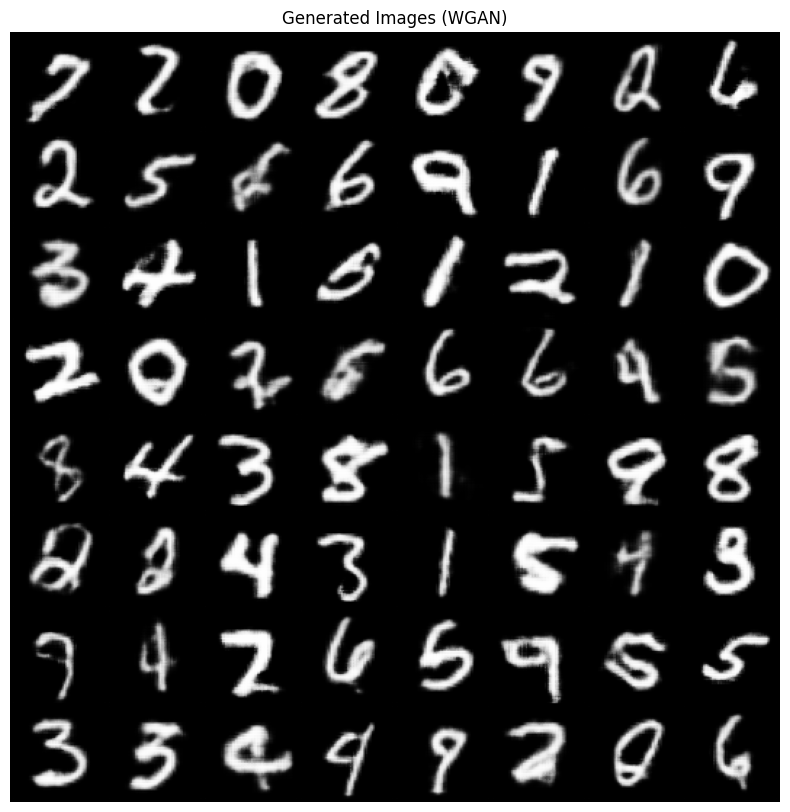

In [11]:
import matplotlib.pyplot as plt
import torchvision

# 1. Switch to evaluation mode (turns off Instantnorm behavior for training)
gen.eval()

# 2. Generate noise vectors
# We generate 32 examples to look at
n_samples = 64
noise = torch.randn(n_samples, Z_DIM, 1, 1).to(device)

# 3. Generate fake images from the noise
with torch.no_grad():
    fake_images = gen(noise)

# 4. Create a grid for visualization
# normalize=True shifts the image from range [-1, 1] to [0, 1] for display
img_grid = torchvision.utils.make_grid(fake_images, normalize=True, nrow=8)

# 5. Plot the grid
plt.figure(figsize=(10, 10))
# PyTorch tensors are (C, H, W), but Matplotlib needs (H, W, C), so we permute
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title("Generated Images (WGAN)")
plt.show()

# 6. Switch back to train mode if you plan to continue training
#gen.train()